# Plot alignment statistics of barcode library

## Load libraries and define analysis-specific parameters

PB: We should add rasilabRtemplates to the Docker and Singularity containers. 

In [1]:
suppressMessages(library(Biostrings))
suppressMessages(library(plyranges))
suppressMessages(library(tidyverse))

## Read alignment log

In [2]:
align_log <- list.files("../data/alignments/", pattern = "*.log", full.names = T) %>% 
  enframe("sno", "file") %>% 
  mutate(log = map(file, readLines)) %>% 
  mutate(sample_name = str_extract(file, "[^/]+(?=.bowtie2.log)")) %>% 
  select(-sno, -file) %>% 
  unnest() %>% 
  print()

Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(log)`”


# A tibble: 12 × 2
   log                                              sample_name           
   <chr>                                            <chr>                 
 1 "109582073 reads; of these:"                     dicodon_grna_barcode_1
 2 "  109582073 (100.00%) were unpaired; of these:" dicodon_grna_barcode_1
 3 "    24362472 (22.23%) aligned 0 times"          dicodon_grna_barcode_1
 4 "    85217812 (77.77%) aligned exactly 1 time"   dicodon_grna_barcode_1
 5 "    1789 (0.00%) aligned >1 times"              dicodon_grna_barcode_1
 6 "77.77% overall alignment rate"                  dicodon_grna_barcode_1
 7 "120677900 reads; of these:"                     dicodon_mrna_barcode_1
 8 "  120677900 (100.00%) were unpaired; of these:" dicodon_mrna_barcode_1
 9 "    27050023 (22.42%) aligned 0 times"          dicodon_mrna_barcode_1
10 "    93627099 (77.58%) aligned exactly 1 time"   dicodon_mrna_barcode_1
11 "    778 (0.00%) aligned >1 times"               dicodon_mrna_barcode_1
12 "77

##  How many total reads and reads with expected barcodes?


── Column specification ────────────────────────────────────────────────────────
cols(
  sample_name = col_character(),
  type = col_character(),
  count = col_double()
)



# A tibble: 6 × 4
  sample_name            read  type       count
  <chr>                  <chr> <chr>      <dbl>
1 dicodon_grna_barcode_1 total all    109582073
2 dicodon_grna_barcode_1 aln   unique  85217812
3 dicodon_grna_barcode_1 aln   multi       1789
4 dicodon_mrna_barcode_1 total all    120677900
5 dicodon_mrna_barcode_1 aln   unique  93627099
6 dicodon_mrna_barcode_1 aln   multi        778


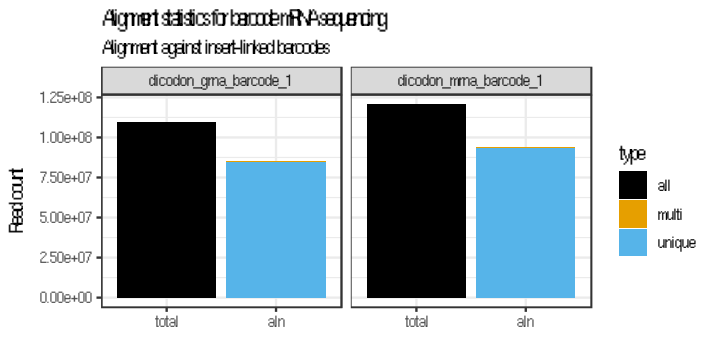

In [3]:
options(repr.plot.width=6, repr.plot.height=3)

plot_data <- align_log %>% 
  mutate(total_all = str_extract(log, "^[:digit:]+(?= reads;)")) %>% 
  mutate(aln_unique = str_extract(log, "[:digit:]+(?=.+exactly)")) %>% 
  mutate(aln_multi = str_extract(log, "[:digit:]+(?=.+>1)")) %>% 
  select(-log) %>% 
  pivot_longer(-sample_name, names_to = 'type', values_to = 'count') %>% 
  filter(!is.na(count)) %>% 
  type_convert() %>% 
  separate(type, c("read", "type")) %>% 
  print()

plot_data %>% 
  ggplot(aes(x = fct_rev(read), y = count, fill = type)) +
  facet_wrap(~sample_name, ncol = 2, scales = "free_x") +
  geom_col() +
  ggthemes::scale_fill_colorblind() +
  theme_bw() +
  labs(x = "", y = "Read count",
       title = "Alignment statistics for barcode mRNA sequencing",
       subtitle = "Alignment against insert-linked barcodes")

## Get readcounts for each barcode

In [4]:
barcode_counts <- list.files("../data/barcode_counts/", pattern = ".tsv.gz$", full.names = T) %>% 
  enframe("sno", "file") %>% 
  mutate(counts = map(file, read_tsv)) %>% 
  mutate(sample_name = str_extract(file, "[^/]+(?=.tsv.gz)")) %>% 
  select(-sno, -file) %>% 
  unnest() %>% 
  rename(barcode_count = count, barcode_num = barcode) %>% 
  mutate(sample_name = str_extract(sample_name, ".+(?=_barcode)")) %>% 
  print()

Rows: 134231 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (2): barcode, count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 136202 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (2): barcode, count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(counts)`”


# A tibble: 270,433 × 3
   barcode_num barcode_count sample_name 
         <dbl>         <dbl> <chr>       
 1        1303         43068 dicodon_grna
 2      434926         17363 dicodon_grna
 3       15655         14231 dicodon_grna
 4      284711         14113 dicodon_grna
 5      434898         14103 dicodon_grna
 6      430480         13708 dicodon_grna
 7      434972         12663 dicodon_grna
 8       21478         12214 dicodon_grna
 9      375595         11769 dicodon_grna
10        7605         11508 dicodon_grna
# … with 270,423 more rows


## Get insert-barcode linkages

In [5]:
align_log <- list.files("../data/alignments/", pattern = "*.log", full.names = T) %>% print 

insert_barcode_linkages <- list.files("../../pool1_linkage/data/filtered_barcodes/", 
                                      pattern = ".tsv.gz$", full.names = T) %>% 
  enframe("sno", "file") %>% 
  mutate(counts = map(file, read_tsv)) %>% 
  mutate(sample_name = str_extract(file, "[^/]+(?=.tsv.gz)")) %>% 
  select(-sno, -file) %>% 
  unnest(cols = c(counts)) %>%
  rename(linkage_count = read_count, linkage_ref = sample_name) %>% 
  select(-barcode_1) %>%
  print()

[1] "../data/alignments//dicodon_grna_barcode_1.bowtie2.log"
[2] "../data/alignments//dicodon_mrna_barcode_1.bowtie2.log"


Rows: 434975 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): barcode_1
dbl (3): insert_num, barcode_num, read_count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 434,975 × 4
   insert_num barcode_num linkage_count linkage_ref    
        <dbl>       <dbl>         <dbl> <chr>          
 1       4888           1             1 dicodon_linkage
 2       1037           2             1 dicodon_linkage
 3       1290           3             1 dicodon_linkage
 4       4911           4             1 dicodon_linkage
 5       1079           5             1 dicodon_linkage
 6       4562           6             1 dicodon_linkage
 7       1093           7             1 dicodon_linkage
 8       5206           8             1 dicodon_linkage
 9        332           9             1 dicodon_linkage
10       4813          10             1 dicodon_linkage
# … with 434,965 more rows


## Get sample annotations

In [6]:

sample_annotations <- read_csv("../annotations/sample_annotations.csv", comment = "#") %>% print()

Rows: 2 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): owner, sample_name, plasmid, library_type, sample_id, linkage_ref
dbl (5): barcode1_read, barcode1_start, barcode1_length, barcode1_trim5, bar...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 2 × 11
  owner sample…¹ plasmid libra…² sampl…³ barco…⁴ barco…⁵ barco…⁶ linka…⁷ barco…⁸
  <chr> <chr>    <chr>   <chr>   <chr>     <dbl>   <dbl>   <dbl> <chr>     <dbl>
1 pb    dicodon… pPBHS2… grna    100p2         1       0      24 dicodo…       3
2 pb    dicodon… pPBHS2… mrna    100p3         1       0      24 dicodo…       3
# … with 1 more variable: barcode1_trim3 <dbl>, and abbreviated variable names
#   ¹​sample_name, ²​library_type, ³​sample_id, ⁴​barcode1_read, ⁵​barcode1_start,
#   ⁶​barcode1_length, ⁷​linkage_ref, ⁸​barcode1_trim5


## Combine barcodes counts with insert linkages

In [7]:
barcode_insert_counts <- barcode_counts %>% 
  left_join(select(sample_annotations, sample_name, linkage_ref, sample_id, library_type), by = "sample_name") %>% 
  left_join(insert_barcode_linkages, by = c("linkage_ref", "barcode_num")) %>%
  print()

# A tibble: 270,433 × 8
   barcode_num barcode_count sample_name linka…¹ sampl…² libra…³ inser…⁴ linka…⁵
         <dbl>         <dbl> <chr>       <chr>   <chr>   <chr>     <dbl>   <dbl>
 1        1303         43068 dicodon_gr… dicodo… 100p2   grna       3842       1
 2      434926         17363 dicodon_gr… dicodo… 100p2   grna       3267     497
 3       15655         14231 dicodon_gr… dicodo… 100p2   grna       3499       1
 4      284711         14113 dicodon_gr… dicodo… 100p2   grna       5285      39
 5      434898         14103 dicodon_gr… dicodo… 100p2   grna        783     401
 6      430480         13708 dicodon_gr… dicodo… 100p2   grna       4915     154
 7      434972         12663 dicodon_gr… dicodo… 100p2   grna       5436    1548
 8       21478         12214 dicodon_gr… dicodo… 100p2   grna        697       1
 9      375595         11769 dicodon_gr… dicodo… 100p2   grna       2978      70
10        7605         11508 dicodon_gr… dicodo… 100p2   grna       2609       1
# … 

# Write barcode insert counts to a table for post-processing

In [9]:
barcode_insert_counts %>% 
  select(sample_id, sample_name, insert_num, barcode_num, barcode_count, linkage_count, library_type, linkage_ref) %>% 
  write_tsv('../tables/sample_insert_barcode_counts.tsv.gz') %>%
  print()

# A tibble: 270,433 × 8
   sample_id sample_name  insert_num barcode_num barco…¹ linka…² libra…³ linka…⁴
   <chr>     <chr>             <dbl>       <dbl>   <dbl>   <dbl> <chr>   <chr>  
 1 100p2     dicodon_grna       3842        1303   43068       1 grna    dicodo…
 2 100p2     dicodon_grna       3267      434926   17363     497 grna    dicodo…
 3 100p2     dicodon_grna       3499       15655   14231       1 grna    dicodo…
 4 100p2     dicodon_grna       5285      284711   14113      39 grna    dicodo…
 5 100p2     dicodon_grna        783      434898   14103     401 grna    dicodo…
 6 100p2     dicodon_grna       4915      430480   13708     154 grna    dicodo…
 7 100p2     dicodon_grna       5436      434972   12663    1548 grna    dicodo…
 8 100p2     dicodon_grna        697       21478   12214       1 grna    dicodo…
 9 100p2     dicodon_grna       2978      375595   11769      70 grna    dicodo…
10 100p2     dicodon_grna       2609        7605   11508       1 grna    dicodo…
# … 

## Plot the number of barcodes per library

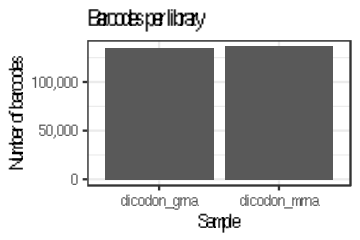

In [10]:
options(repr.plot.width=3, repr.plot.height=2)

plot_data <- barcode_insert_counts %>% 
  group_by(sample_name) %>% 
  distinct(barcode_num) %>% 
  summarize(n_barcodes = dplyr::n()) %>% 
  ungroup()

plot_data %>% 
  ggplot(aes(x = sample_name, y = n_barcodes)) +
  geom_col(position = "dodge") +
  theme_bw() +
  scale_y_continuous(labels = scales::comma) +
  # theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(x = "Sample", y = "Number of barcodes", title = "Barcodes per library") +
  NULL

## Plot CDF of the number of reads per barcode

# A tibble: 270,433 × 9
   barcode_num barcode_c…¹ sampl…² linka…³ sampl…⁴ libra…⁵ inser…⁶ linka…⁷ xaxis
         <dbl>       <dbl> <chr>   <chr>   <chr>   <chr>     <dbl>   <dbl> <int>
 1        1303       43068 dicodo… dicodo… 100p2   grna       3842       1     1
 2      412619       30854 dicodo… dicodo… 100p3   mrna       5739     101     1
 3      434876       30521 dicodo… dicodo… 100p3   mrna       5963     361     2
 4      365881       28972 dicodo… dicodo… 100p3   mrna       5968      65     3
 5      434974       23639 dicodo… dicodo… 100p3   mrna       4064    1817     4
 6      364308       20936 dicodo… dicodo… 100p3   mrna       3566      64     5
 7      274739       20474 dicodo… dicodo… 100p3   mrna        999      37     6
 8      434807       20362 dicodo… dicodo… 100p3   mrna       5199     301     7
 9      109280       20050 dicodo… dicodo… 100p3   mrna       1495      11     8
10      423241       19404 dicodo… dicodo… 100p3   mrna       3004     122     9
# … 

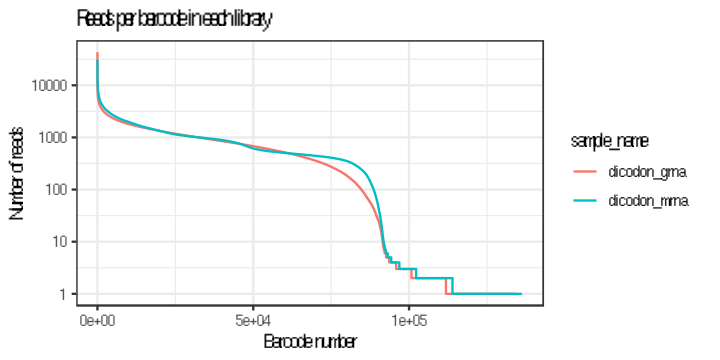

In [11]:
options(repr.plot.width=6, repr.plot.height=3)

plot_data <- barcode_insert_counts %>% 
  group_by(sample_name) %>% 
  arrange(-barcode_count) %>% 
  mutate(xaxis = 1:(dplyr::n())) %>% 
  ungroup() %>% 
  print()

plot_data %>% 
  ggplot(aes(x = xaxis, y = barcode_count, color = sample_name)) +
  geom_line(aes(group = sample_name)) +
  theme_bw() +
  scale_y_log10() +
  labs(x = "Barcode number", y = "Number of reads",
       title = "Reads per barcode in each library") +
  NULL

## Plot CDF of the number of reads per insert, summed over barcodes

`summarise()` has grouped output by 'sample_name'. You can override using the
`.groups` argument.


# A tibble: 11,659 × 4
   sample_name  insert_num read_count xaxis
   <chr>             <dbl>      <dbl> <int>
 1 dicodon_mrna       3900     181875     1
 2 dicodon_mrna       4237     158977     2
 3 dicodon_grna       3267     123450     1
 4 dicodon_grna       3132     109091     2
 5 dicodon_mrna        909     108483     3
 6 dicodon_mrna       3267     105679     4
 7 dicodon_grna       4237      98462     3
 8 dicodon_mrna       3315      92503     5
 9 dicodon_grna       3842      91271     4
10 dicodon_mrna         69      87950     6
# … with 11,649 more rows


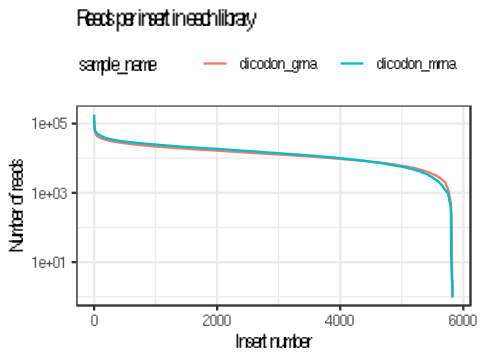

In [12]:
options(repr.plot.width=4, repr.plot.height=3)

plot_data <- barcode_insert_counts %>% 
  group_by(sample_name, insert_num) %>% 
  summarize(read_count = sum(barcode_count)) %>% 
  ungroup() %>% 
  group_by(sample_name) %>% 
  arrange(-read_count) %>% 
  mutate(xaxis = 1:(dplyr::n())) %>% 
  ungroup() %>% 
  print()

plot_data %>% 
  ggplot(aes(x = xaxis, y = read_count, color = sample_name)) +
  geom_line(aes(group = sample_name)) +
  theme_bw() +
  theme(legend.position = "top") +
  scale_y_log10() +
  labs(x = "Insert number", y = "Number of reads",
       title = "Reads per insert in each library") +
  NULL

## Plot read counts of mRNA vs gRNA, summed for each insert


`summarise()` has grouped output by 'library_type'. You can override using the
`.groups` argument.


# A tibble: 5,833 × 3
   insert_num  grna  mrna
        <dbl> <dbl> <dbl>
 1          0 15453 21721
 2          1 56850 36288
 3          2 36228 56963
 4          3 20934 16840
 5          4 41089 26572
 6          5 36664 18781
 7          6 17791 15073
 8          7 23158 22474
 9          8 42684 31335
10          9 31420 23818
# … with 5,823 more rows


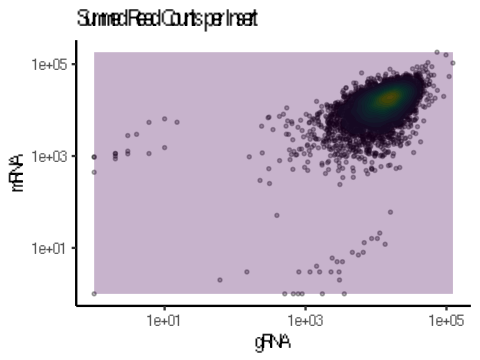

In [13]:
plot_data <- barcode_insert_counts %>% 
  group_by(library_type, insert_num) %>%
  summarize(read_count = sum(barcode_count)) %>%
  ungroup() %>%
  select(insert_num, read_count, library_type) %>%
  pivot_wider(names_from = "library_type", values_from = "read_count") %>%
  print()

plot_data %>%
  filter(!is.na(grna), !is.na(mrna)) %>%
  ggplot(aes(x = grna, y = mrna)) +
  geom_point(alpha = 0.3, size = 0.5) +
  geom_density_2d_filled(alpha = 0.3, show.legend = F) +
  theme_classic() +
  scale_x_log10() +
  scale_y_log10() +
  labs(x = "gRNA", y = "mRNA",
       title = "Summed Read Counts per Insert") +
  NULL